# load dependencies

In [76]:
from collections import defaultdict
import json, math, gdown
import numpy as np
import pandas as pd
import plotly.express as px
from tqdm import tqdm
import requests
pd.options.display.float_format = '{:.2f}'.format

# Re-import necessary libraries and reload the dataset, as the previous session context was lost.
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

import numpy as np

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load chatbot-arena-conversations as data frame

In [77]:

battles = pd.read_json(
    "data/nlp-chatbot-analysis_data/training-set/chatbot-arena-conversations.jsonl.gz",
    lines=True,
    compression="gzip")

# Count classes

In [78]:
battles["winner"].value_counts()

winner
model_a          9002
model_b          8862
tie (bothbad)    4632
tie              2786
Name: count, dtype: int64

In [79]:
battles_no_ties = battles[~battles["winner"].str.contains("tie")]

In [80]:
fig = px.bar(pd.concat([battles["model_a"], battles["model_b"]]).value_counts(),
             title="Battle Count for Each Model", text_auto=True)
fig.update_layout(xaxis_title="model", yaxis_title="Battle Count", height=400,
                  showlegend=False)
fig

# Show each count of a model fighting every other model

In [81]:
def visualize_battle_count(battles, title, show_num_models=30):
    ptbl = pd.pivot_table(battles, index="model_a", columns="model_b", aggfunc="size",
                          fill_value=0)
    battle_counts = ptbl + ptbl.T
    ordering = battle_counts.sum().sort_values(ascending=False).index
    ordering = ordering[:show_num_models]
    fig = px.imshow(battle_counts.loc[ordering, ordering],
                    title=title, text_auto=True)
    fig.update_layout(xaxis_title="Model B",
                      yaxis_title="Model A",
                      xaxis_side="top", height=800, width=800,
                      title_y=0.07, title_x=0.5,
                      font=dict(size=10))
    fig.update_traces(hovertemplate=
                      "Model A: %{y}<br>Model B: %{x}<br>Count: %{z}<extra></extra>")
    return fig

fig = visualize_battle_count(battles, title="Battle Count of Each Combination of Models", show_num_models=30)
fig

In [82]:
visualize_battle_count(battles_no_ties, "Battle Count for Each Combination of Models (without Ties)")

# Show the number of wins of each model vs every other Model

In [83]:
visualize_battle_count(battles[battles['winner'].str.contains("tie")], "Tie Count for Each Combination of Models")

In [84]:
def compute_pairwise_win_fraction(battles, max_num_models=30):
    # Times each model wins as Model A
    a_win_ptbl = pd.pivot_table(
        battles[battles['winner'] == "model_a"],
        index="model_a", columns="model_b", aggfunc="size", fill_value=0)

    # Table counting times each model wins as Model B
    b_win_ptbl = pd.pivot_table(
        battles[battles['winner'] == "model_b"],
        index="model_a", columns="model_b", aggfunc="size", fill_value=0)

    # Table counting number of A-B pairs
    num_battles_ptbl = pd.pivot_table(battles,
        index="model_a", columns="model_b", aggfunc="size", fill_value=0)

    # Computing the proportion of wins for each model as A and as B
    # against all other models
    row_beats_col_freq = (
        (a_win_ptbl + b_win_ptbl.T) /
        (num_battles_ptbl + num_battles_ptbl.T)
    )

    # Arrange ordering according to proprition of wins
    prop_wins = row_beats_col_freq.mean(axis=1).sort_values(ascending=False)
    prop_wins = prop_wins[:max_num_models]
    model_names = list(prop_wins.keys())
    row_beats_col = row_beats_col_freq.loc[model_names, model_names]
    return row_beats_col

def visualize_pairwise_win_fraction(battles, title, max_num_models=30):
    row_beats_col = compute_pairwise_win_fraction(battles, max_num_models)
    fig = px.imshow(row_beats_col, color_continuous_scale='RdBu',
                    text_auto=".2f", title=title)
    fig.update_layout(xaxis_title=" Model B: Loser",
                  yaxis_title="Model A: Winner",
                  xaxis_side="top", height=900, width=900,
                  title_y=0.07, title_x=0.5)
    fig.update_traces(hovertemplate=
                  "Model A: %{y}<br>Model B: %{x}<br>Fraction of A Wins: %{z}<extra></extra>")

    return fig

In [85]:
fig = visualize_pairwise_win_fraction(battles_no_ties,
      title = "Fraction of Model A Wins for All Non-tied A vs. B Battles")
fig

# show Win rate of each model

In [86]:
row_beats_col_freq = compute_pairwise_win_fraction(battles_no_ties)
fig = px.bar(row_beats_col_freq.mean(axis=1).sort_values(ascending=False),
             title="Average Win Rate Against All Other Models (Assuming Uniform Sampling and No Ties)",
             text_auto=".2f")
fig.update_layout(yaxis_title="Average Win Rate", xaxis_title="Model",
                  showlegend=False)
fig

# define ELO calculation

In [87]:
def compute_online_elo(battles, K=4, SCALE=400, BASE=10, INIT_RATING=1000):
    rating = defaultdict(lambda: INIT_RATING)

    for rd, model_a, model_b, winner in battles[['model_a', 'model_b', 'winner']].itertuples():
        ra = rating[model_a]
        rb = rating[model_b]
        ea = 1 / (1 + BASE ** ((rb - ra) / SCALE))
        eb = 1 / (1 + BASE ** ((ra - rb) / SCALE))
        if winner == "model_a":
            sa = 1
        elif winner == "model_b":
            sa = 0
        elif winner == "tie" or winner == "tie (bothbad)":
            sa = 0.5
        else:
            raise Exception(f"unexpected vote {winner}")
        rating[model_a] += K * (sa - ea)
        rating[model_b] += K * (1 - sa - eb)

    # calibrate llama-13b to 800
    delta = (800-rating["llama-13b"])
    for model in battles["model_a"].unique():
        rating[model] += delta

    return rating

# print ELO rating

In [88]:
def preety_print_model_ratings(ratings):
    df = pd.DataFrame([
        [n, ratings[n]] for n in ratings.keys()
    ], columns=["Model", "Elo rating"]).sort_values("Elo rating", ascending=False).reset_index(drop=True)
    # df["Elo rating"] = (df["Elo rating"] + 0.5).astype(int)
    df.index = df.index + 1
    return df

online_elo_ratings = compute_online_elo(battles)
preety_print_model_ratings(online_elo_ratings)

,Model,Elo rating
1,gpt-4,1146.03
2,claude-v1,1128.89
3,claude-instant-v1,1110.60
4,gpt-3.5-turbo,1043.78
5,guanaco-33b,1033.25
6,palm-2,1003.55
7,vicuna-13b,1002.95
8,wizardlm-13b,988.43
9,koala-13b,984.48
10,vicuna-7b,980.23


In [89]:
def compute_mle_elo(
    df, SCALE=400, BASE=10, INIT_RATING=1000, sample_weight=None
):
    from sklearn.linear_model import LogisticRegression
    ptbl_a_win = pd.pivot_table(
        df[df["winner"] == "model_a"],
        index="model_a",
        columns="model_b",
        aggfunc="size",
        fill_value=0,
    )
    # if no tie, create a zero matrix
    if sum(df["winner"].isin(["tie", "tie (bothbad)"])) == 0:
        ptbl_tie = pd.DataFrame(0, index=ptbl_a_win.index, columns=ptbl_a_win.columns)
    else:
        ptbl_tie = pd.pivot_table(
            df[df["winner"].isin(["tie", "tie (bothbad)"])],
            index="model_a",
            columns="model_b",
            aggfunc="size",
            fill_value=0,
        )
        ptbl_tie = ptbl_tie + ptbl_tie.T

    ptbl_b_win = pd.pivot_table(
        df[df["winner"] == "model_b"],
        index="model_a",
        columns="model_b",
        aggfunc="size",
        fill_value=0,
    )
    ptbl_win = ptbl_a_win * 2 + ptbl_b_win.T * 2 + ptbl_tie

    models = pd.Series(np.arange(len(ptbl_win.index)), index=ptbl_win.index)

    p = len(models)
    X = np.zeros([p * (p - 1) * 2, p])
    Y = np.zeros(p * (p - 1) * 2)

    cur_row = 0
    sample_weights = []
    for m_a in ptbl_win.index:
        for m_b in ptbl_win.columns:
            if m_a == m_b:
                continue
            # if nan skip
            if math.isnan(ptbl_win.loc[m_a, m_b]) or math.isnan(ptbl_win.loc[m_b, m_a]):
                continue
            X[cur_row, models[m_a]] = +math.log(BASE)
            X[cur_row, models[m_b]] = -math.log(BASE)
            Y[cur_row] = 1.0
            sample_weights.append(ptbl_win.loc[m_a, m_b])

            X[cur_row + 1, models[m_a]] = math.log(BASE)
            X[cur_row + 1, models[m_b]] = -math.log(BASE)
            Y[cur_row + 1] = 0.0
            sample_weights.append(ptbl_win.loc[m_b, m_a])
            cur_row += 2
    X = X[:cur_row]
    Y = Y[:cur_row]

    lr = LogisticRegression(fit_intercept=False, penalty=None, tol=1e-6)
    lr.fit(X, Y, sample_weight=sample_weights)
    elo_scores = SCALE * lr.coef_[0] + INIT_RATING
    if "mixtral-8x7b-instruct-v0.1" in models.index:
        elo_scores += 1114 - elo_scores[models["mixtral-8x7b-instruct-v0.1"]]
    return pd.Series(elo_scores, index=models.index).sort_values(ascending=False)

elo_mle_ratings = compute_mle_elo(battles)

In [90]:
# Main Dataset

# Conversation Data -- we will use this data in the "Conversation Data" section

#used to find winner for the Y value


df = pd.read_json(
    "data/nlp-chatbot-analysis_data/training-set/chatbot-arena-conversations.jsonl.gz",
    lines=True,
    compression="gzip"
)

df.head(5)


,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,[{'content': 'What is the difference between O...,[{'content': 'What is the difference between O...
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,[{'content': 'Why did my parent not invite me ...,[{'content': 'Why did my parent not invite me ...
2,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,model_b,arena_user_973,"[{'content': 'Fuji vs. Nikon, which is better?...","[{'content': 'Fuji vs. Nikon, which is better?..."
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,[{'content': 'How to build an arena for chatbo...,[{'content': 'How to build an arena for chatbo...
4,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,model_a,arena_user_973,"[{'content': 'When is it today?', 'role': 'use...","[{'content': 'When is it today?', 'role': 'use..."


In [91]:
# Auxiliary Datasets

# Embedding Data -- we will use this data in the "Embedding Data" section
prompt_embeddings = np.load(
    "data/nlp-chatbot-analysis_data/training-set/chatbot-arena-prompts-embeddings.npy"

)

response_a_embeddings = np.load(
    "data/nlp-chatbot-analysis_data/training-set/chatbot-arena-model_a_response-embeddings.npy"
)

response_b_embeddings = np.load(
    "data/nlp-chatbot-analysis_data/training-set/chatbot-arena-model_b_response-embeddings.npy"
)

In [92]:
prompt_embeddings = pd.DataFrame(prompt_embeddings)
prompt_embeddings.columns = ["prompt_embeddings_" + str(col) for col in prompt_embeddings.columns]
response_a_embeddings = pd.DataFrame(response_a_embeddings)
response_a_embeddings.columns = ["response_a_embeddings_" + str(col) for col in response_a_embeddings.columns]
response_b_embeddings = pd.DataFrame(response_b_embeddings)
response_b_embeddings.columns = ["response_b_embeddings_" + str(col) for col in response_b_embeddings.columns]

In [93]:
df_embeddings_prompt_a = pd.concat([prompt_embeddings, response_a_embeddings], axis=1)

df_embeddings_prompt_a_b = pd.concat([df_embeddings_prompt_a, response_b_embeddings], axis=1)

In [94]:

df_embeddings_prompt_a_b

,prompt_embeddings_0,prompt_embeddings_1,prompt_embeddings_2,prompt_embeddings_3,prompt_embeddings_4,prompt_embeddings_5,prompt_embeddings_6,prompt_embeddings_7,prompt_embeddings_8,prompt_embeddings_9,...,response_b_embeddings_246,response_b_embeddings_247,response_b_embeddings_248,response_b_embeddings_249,response_b_embeddings_250,response_b_embeddings_251,response_b_embeddings_252,response_b_embeddings_253,response_b_embeddings_254,response_b_embeddings_255
0,-0.12,-0.12,0.05,0.02,0.09,-0.03,0.00,-0.08,0.09,-0.00,...,-0.02,-0.09,0.01,-0.01,0.04,0.05,-0.09,-0.03,0.01,-0.06
1,0.01,0.03,-0.09,0.04,-0.08,-0.05,-0.05,-0.03,-0.08,0.05,...,0.01,-0.04,-0.02,0.13,0.06,-0.13,0.03,-0.04,-0.05,-0.04
2,-0.04,-0.11,-0.02,-0.04,0.04,-0.05,-0.01,0.03,0.03,0.02,...,-0.08,-0.00,-0.02,0.03,0.07,0.03,-0.01,-0.11,0.08,-0.06
3,-0.05,-0.00,0.09,0.03,-0.04,-0.10,-0.02,0.01,-0.06,0.05,...,-0.05,-0.14,0.16,0.03,0.03,0.03,-0.01,-0.03,0.05,-0.09
4,-0.04,0.05,0.06,0.05,0.05,-0.02,0.06,0.05,-0.07,-0.02,...,0.04,-0.06,-0.06,0.12,0.14,-0.05,-0.03,-0.06,-0.02,-0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25277,-0.04,-0.03,-0.02,-0.09,-0.09,-0.02,0.08,-0.01,0.05,-0.03,...,-0.12,-0.03,0.06,-0.05,-0.01,-0.03,0.04,-0.09,-0.08,0.11
25278,0.05,-0.14,0.05,0.13,0.09,0.01,0.10,0.08,-0.04,-0.04,...,0.01,-0.02,0.04,0.07,-0.00,-0.02,0.00,-0.03,-0.06,0.02
25279,0.02,-0.03,0.07,-0.09,-0.03,-0.03,0.00,-0.08,-0.02,-0.04,...,0.00,-0.08,0.08,-0.06,0.00,0.02,-0.02,-0.11,0.00,0.07
25280,0.02,0.04,0.08,-0.11,-0.03,-0.03,0.03,0.02,0.04,0.07,...,-0.05,-0.03,0.04,0.06,0.06,-0.07,0.03,-0.05,0.08,0.01


In [95]:
# loads the Y values for the traning data set


df_model_name = pd.read_json(
    "Data/nlp-chatbot-analysis_data/training-set/chatbot-arena-conversations.jsonl.gz",
    lines=True,
    compression="gzip"
)

In [96]:
#calcualte ELO for traning data set

df_elo = preety_print_model_ratings(elo_mle_ratings)
df_elo_a = df_elo.rename(columns={
    'Model': 'model_a',
    'Elo rating': 'Elo rating a'
})

df_elo_b = df_elo.rename(columns={
    'Model': 'model_b',
    'Elo rating': 'Elo rating b'
})


In [97]:
# Merge all feature data sets

merged_df = df_model_name.merge(df_elo_a[['model_a', 'Elo rating a']], on='model_a', how='left')
merged_df = merged_df.merge(df_elo_b[['model_b', 'Elo rating b']], on='model_b', how='left')


df_encoded = pd.concat([
    pd.Series(merged_df["Elo rating a"]),
    pd.Series(merged_df["Elo rating b"])
], axis=1)

final= pd.concat([df_encoded,df_embeddings_prompt_a_b], axis=1)

cat_winner = pd.Categorical(df_model_name["winner"])

final = pd.concat([
    final, 
    pd.Series(cat_winner.codes, name="winner_encoded")
], axis=1)


# convert all column names to type string
final.columns = final.columns.astype(str)

# Make train and test data set

In [98]:
df = final

# Display basic info and check for missing values
print(df.info())
print(df.isnull().sum())

# Assume the target column is the last column and features are the rest
target_column = df.columns[-1]
X = df.drop(target_column, axis=1)  # Now X excludes the target col
y = df[target_column]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=40)

print("columns",X_train.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25282 entries, 0 to 25281
Columns: 771 entries, Elo rating a to winner_encoded
dtypes: float32(768), float64(2), int8(1)
memory usage: 74.5 MB
None
Elo rating a                 0
Elo rating b                 0
prompt_embeddings_0          0
prompt_embeddings_1          0
prompt_embeddings_2          0
                            ..
response_b_embeddings_252    0
response_b_embeddings_253    0
response_b_embeddings_254    0
response_b_embeddings_255    0
winner_encoded               0
Length: 771, dtype: int64
columns Index(['Elo rating a', 'Elo rating b', 'prompt_embeddings_0',
       'prompt_embeddings_1', 'prompt_embeddings_2', 'prompt_embeddings_3',
       'prompt_embeddings_4', 'prompt_embeddings_5', 'prompt_embeddings_6',
       'prompt_embeddings_7',
       ...
       'response_b_embeddings_246', 'response_b_embeddings_247',
       'response_b_embeddings_248', 'response_b_embeddings_249',
       'response_b_embeddings_250', 'respo

# Train Model

Accuracy: 0.55
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.69      0.62       880
           1       0.59      0.68      0.63       888
           2       0.28      0.08      0.12       262
           3       0.46      0.32      0.38       499

    accuracy                           0.55      2529
   macro avg       0.47      0.44      0.44      2529
weighted avg       0.52      0.55      0.52      2529



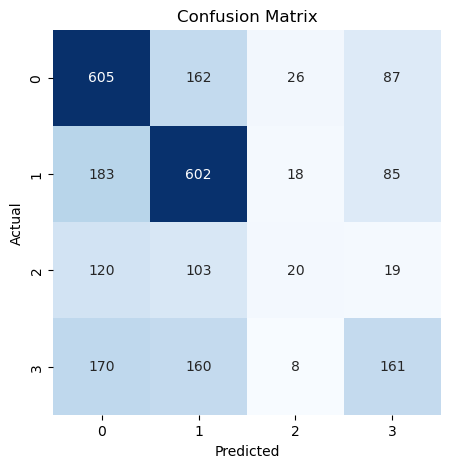

In [99]:



# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [100]:
X_scale = scaler.transform(X)

# Cross-validation

In [101]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_scale, y, cv=5, scoring='accuracy')  # or 'roc_auc', etc.
print("Cross-validation scores:", scores)
print("Mean score:", scores.mean())

Cross-validation scores: [0.52224639 0.57603322 0.55498418 0.53481013 0.50573576]
Mean score: 0.5387619351419138


Accuracy: 0.59
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.73      0.66      9002
           1       0.60      0.72      0.65      8862
           2       0.47      0.11      0.18      2786
           3       0.53      0.37      0.44      4632

    accuracy                           0.59     25282
   macro avg       0.55      0.48      0.48     25282
weighted avg       0.57      0.59      0.56     25282



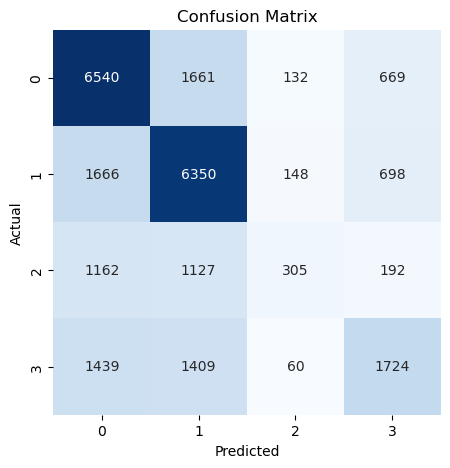

<Figure size 640x480 with 0 Axes>

In [102]:
# Make predictions
y_pred = model.predict(X_scale)

# Evaluate the model
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y, y_pred))

# Display the confusion matrix
conf_matrix = confusion_matrix(y, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# plt.# savefig("figures/Task_A_Confusion_matrix.png", dpi=300, bbox_inches='tight')

# Test data set

# load files as Numpy Array

In [103]:
# Auxiliary Datasets

prompt_embeddings = pd.DataFrame
response_a_embeddings = pd.DataFrame
response_b_embeddings = pd.DataFrame


# Embedding Data -- we will use this data in the "Embedding Data" section
prompt_embeddings = np.load(
    "data/nlp-chatbot-analysis_data/test-set/arena-test-set-prompts-embeddings.npy"

)

response_a_embeddings = np.load(
    "data/nlp-chatbot-analysis_data/test-set/arena-test-set-model_a_response-embeddings.npy"
)

response_b_embeddings = np.load(
    "data/nlp-chatbot-analysis_data/test-set/arena-test-set-model_b_response-embeddings.npy"
)


In [104]:
prompt_embeddings = pd.DataFrame(prompt_embeddings)
prompt_embeddings.columns = ["prompt_embeddings_" + str(col) for col in prompt_embeddings.columns]
response_a_embeddings = pd.DataFrame(response_a_embeddings)
response_a_embeddings.columns = ["response_a_embeddings_" + str(col) for col in response_a_embeddings.columns]
response_b_embeddings = pd.DataFrame(response_b_embeddings)
response_b_embeddings.columns = ["response_b_embeddings_" + str(col) for col in response_b_embeddings.columns]

df_embeddings_prompt_a = pd.concat([prompt_embeddings, response_a_embeddings], axis=1)
df_embeddings_prompt_a_b = pd.concat([df_embeddings_prompt_a, response_b_embeddings], axis=1)

In [105]:
# calculate ELO raitings for the traning data

df_elo = preety_print_model_ratings(elo_mle_ratings)
df_elo_a = df_elo.rename(columns={
    'Model': 'model_a',
    'Elo rating': 'Elo rating a'
})

df_elo_b = df_elo.rename(columns={
    'Model': 'model_b',
    'Elo rating': 'Elo rating b'
})

df_elo_a

,model_a,Elo rating a
1,gpt-4,1233.27
2,claude-v1,1187.56
3,claude-instant-v1,1164.99
4,gpt-3.5-turbo,1127.54
5,guanaco-33b,1084.55
6,palm-2,1074.47
7,vicuna-13b,1053.70
8,wizardlm-13b,1047.24
9,vicuna-7b,1017.56
10,koala-13b,1005.70


In [106]:
# load models name for model A and model B
df_model_name = pd.read_json(
    "data/nlp-chatbot-analysis_data/test-set/arena-test-set-prompt-and-responses.jsonl.gz",
    lines=True,
    compression="gzip"
)

df.head(5)

,Elo rating a,Elo rating b,prompt_embeddings_0,prompt_embeddings_1,prompt_embeddings_2,prompt_embeddings_3,prompt_embeddings_4,prompt_embeddings_5,prompt_embeddings_6,prompt_embeddings_7,...,response_b_embeddings_247,response_b_embeddings_248,response_b_embeddings_249,response_b_embeddings_250,response_b_embeddings_251,response_b_embeddings_252,response_b_embeddings_253,response_b_embeddings_254,response_b_embeddings_255,winner_encoded
0,896.26,1005.70,-0.12,-0.12,0.05,0.02,0.09,-0.03,0.00,-0.08,...,-0.09,0.01,-0.01,0.04,0.05,-0.09,-0.03,0.01,-0.06,1
1,924.17,917.85,0.01,0.03,-0.09,0.04,-0.08,-0.05,-0.05,-0.03,...,-0.04,-0.02,0.13,0.06,-0.13,0.03,-0.04,-0.05,-0.04,2
2,1005.70,924.17,-0.04,-0.11,-0.02,-0.04,0.04,-0.05,-0.01,0.03,...,-0.00,-0.02,0.03,0.07,0.03,-0.01,-0.11,0.08,-0.06,1
3,1053.70,924.17,-0.05,-0.00,0.09,0.03,-0.04,-0.10,-0.02,0.01,...,-0.14,0.16,0.03,0.03,0.03,-0.01,-0.03,0.05,-0.09,1
4,1053.70,1005.70,-0.04,0.05,0.06,0.05,0.05,-0.02,0.06,0.05,...,-0.06,-0.06,0.12,0.14,-0.05,-0.03,-0.06,-0.02,-0.00,0


In [107]:
# extract Elo ratings based on model name

merged_df = df_model_name.merge(df_elo_a[['model_a', 'Elo rating a']], on='model_a', how='left')
merged_df = merged_df.merge(df_elo_b[['model_b', 'Elo rating b']], on='model_b', how='left')
merged_df

,question_id,prompt,model_a,model_b,model_a_response,model_b_response,Elo rating a,Elo rating b
0,4f332ebd8cdc4ff2be74aa8828ff20d5,what do you think about the future of iran?,koala-13b,vicuna-13b,"As an AI language model, I don't have the abil...","As an AI language model, I do not have persona...",1005.70,1053.70
1,f2be6f13e5ed40e5b81443223996494c,Salut ! Tu es un méchant chatbot !,stablelm-tuned-alpha-7b,vicuna-13b,"lut! Tuer ton pseudo câbleur, câbleur câbleur!...","Salut ! Je suis un chatbot, mais je suis progr...",859.86,1053.70
2,5fafefb8a0c54243afb52d2892946cea,⚔️ Chatbot Arena ⚔️\nRules:\n Chat with two...,koala-13b,vicuna-13b,"Hello! \n\nModel A: Hi there, I'm Model A, a f...","Sure, I can do that! Let's get started.\n\nMod...",1005.70,1053.70
3,7834f572267f40709ecebb273a2b346b,Guess the word that i have in my mind,chatglm-6b,stablelm-tuned-alpha-7b,"I'm sorry, but I'm not able to guess the word ...","I'm sorry, but as an AI language model, I do n...",896.26,859.86
4,1ccc7e58290245c4bd5457fce45f8640,You are a peasant living in the village. But s...,vicuna-13b,koala-13b,"As a peasant living in the village, I would li...","As a peasant living in a village, my thoughts ...",1053.70,1005.70
...,...,...,...,...,...,...,...,...
3195,eb08f8a7f20840c99efe9fc8c03f1c13,Tell me a little about yourself.,wizardlm-13b,fastchat-t5-3b,"As an AI language model, I don't have personal...","As an AI language model, I don't have a physic...",1047.24,904.22
3196,4baca918f1f5440599ae9edb3bfa8cc1,Create an detail outline for one-semester cour...,RWKV-4-Raven-14B,vicuna-7b,"Sure, here is a possible outline for a one-sem...","Sure, here is a detailed outline for a one-sem...",939.96,1017.56
3197,a787ce60dc1440f39455ab20e3bffe33,subquery in select statement,guanaco-33b,gpt-4,"In SQL, a subquery is a query within another q...",A subquery in a SELECT statement is a query th...,1084.55,1233.27
3198,3dc09f20eedb405ab3dc980cf7bff5d0,how to,wizardlm-13b,gpt4all-13b-snoozy,I'm not sure what you're asking. Can you pleas...,"The prompt ""How to"" can be interpreted in diff...",1047.24,956.79


In [108]:
import pandas as pd

# merge Elo ratings 

df_encoded = pd.concat([
    pd.Series(merged_df["Elo rating a"]),
    pd.Series(merged_df["Elo rating b"])
], axis=1)


In [109]:
# merge test features 

final= pd.concat([df_encoded,df_embeddings_prompt_a_b], axis=1)


In [110]:
final.columns = final.columns.astype(str)

In [111]:
final

,Elo rating a,Elo rating b,prompt_embeddings_0,prompt_embeddings_1,prompt_embeddings_2,prompt_embeddings_3,prompt_embeddings_4,prompt_embeddings_5,prompt_embeddings_6,prompt_embeddings_7,...,response_b_embeddings_246,response_b_embeddings_247,response_b_embeddings_248,response_b_embeddings_249,response_b_embeddings_250,response_b_embeddings_251,response_b_embeddings_252,response_b_embeddings_253,response_b_embeddings_254,response_b_embeddings_255
0,1005.70,1053.70,-0.06,-0.12,0.06,0.05,0.01,-0.00,0.06,0.06,...,0.03,-0.08,0.08,0.01,-0.04,-0.01,0.05,0.01,-0.05,-0.10
1,859.86,1053.70,-0.02,-0.03,-0.05,-0.06,-0.00,-0.07,-0.03,0.03,...,-0.03,-0.09,0.05,0.08,0.09,-0.01,0.08,-0.05,-0.02,0.06
2,1005.70,1053.70,0.05,-0.09,0.00,-0.05,-0.02,-0.03,-0.07,-0.00,...,-0.02,-0.15,0.05,0.01,0.06,0.02,0.00,-0.12,-0.03,-0.03
3,896.26,859.86,0.01,-0.04,-0.08,-0.02,-0.07,-0.07,-0.01,0.08,...,0.02,-0.11,0.10,-0.03,0.08,-0.06,0.07,-0.10,-0.09,-0.02
4,1053.70,1005.70,0.05,0.02,0.06,0.02,-0.11,-0.08,0.06,0.03,...,0.06,-0.09,-0.05,0.08,-0.09,0.05,0.13,0.06,-0.05,-0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,1047.24,904.22,0.00,-0.14,-0.10,0.09,-0.01,-0.06,-0.11,0.05,...,0.01,-0.09,0.10,-0.04,0.07,-0.09,0.08,-0.04,-0.05,-0.02
3196,939.96,1017.56,-0.06,0.11,-0.06,-0.05,-0.18,-0.02,-0.08,0.01,...,-0.06,-0.05,0.04,-0.05,0.03,0.00,0.05,-0.03,-0.03,-0.08
3197,1084.55,1233.27,-0.02,-0.07,0.09,-0.02,-0.00,-0.02,0.03,0.02,...,-0.02,-0.01,0.11,0.02,-0.03,-0.03,0.06,-0.08,-0.10,-0.05
3198,1047.24,956.79,0.03,-0.04,-0.03,0.08,-0.12,-0.17,-0.05,-0.00,...,0.00,-0.10,0.08,0.08,0.02,-0.06,0.06,-0.13,-0.02,-0.07


In [112]:
final_scaled = scaler.transform(final)

In [113]:
y_pred = model.predict(final_scaled)

In [114]:
df_id = pd.concat([
    pd.Series(merged_df["question_id"], name="question_id"),
    pd.Series(y_pred, name="winner")
], axis=1)

In [115]:
df_id["winner"].value_counts()

winner
0    1442
1    1297
3     346
2     115
Name: count, dtype: int64

In [116]:
# create final csv format

df_id['hardness_score'] = 0
df_id

,question_id,winner,hardness_score
0,4f332ebd8cdc4ff2be74aa8828ff20d5,1,0
1,f2be6f13e5ed40e5b81443223996494c,1,0
2,5fafefb8a0c54243afb52d2892946cea,1,0
3,7834f572267f40709ecebb273a2b346b,3,0
4,1ccc7e58290245c4bd5457fce45f8640,0,0
...,...,...,...
3195,eb08f8a7f20840c99efe9fc8c03f1c13,0,0
3196,4baca918f1f5440599ae9edb3bfa8cc1,1,0
3197,a787ce60dc1440f39455ab20e3bffe33,1,0
3198,3dc09f20eedb405ab3dc980cf7bff5d0,0,0


In [117]:
df_id["winner"] = cat_winner.categories[df_id["winner"]]


In [118]:
df_id["winner"].value_counts()

winner
model_a          1442
model_b          1297
tie (bothbad)     346
tie               115
Name: count, dtype: int64

In [119]:
df_id.to_csv("output.csv", index=False)

Which model(s) do you use and why?


    I used a logistic regression model as it returns a categorical prediction


How do you use your data for training and testing?


    I spilt the training data set .90/.10 training/testing then use 4 fold Cross validation


Does your model require hyperparameter tuning? If so, how do you approach it?


    I changed the weight of each of the predicted outcomes rebalanced balanced based on the inverse of their frequency in the training data


How do you engineer the features for your model? What are the rationales behind selecting these features?


    I used the embedded prompts and responses to calculate the ELO rating of each model then mapped the Model A and Model B to the ELO ratings. I used this to convert the the strings of the features and responses into a numeric vector and used the ELO as a numeric representation of the Models chance of victory


How do you perform cross-validation on your model?


    I used 4 fold cross validation using the training data set


What loss metrics are you using to evaluate your model? Why?


    I am using accuracy precision recall  f1-score to evaluate my model


From a bias-variance tradeoff standpoint, how do you assess the performance of your model? How do you check if it is overfitting?


    I used cross validation and checked the precision and recall


How would you improve your model based on the outcome?


    add more data on ties or the hardness of the question


Are there any further extensions to your model that would be worth exploring?


    adding the predicted hardness score of the prompts

